In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence
from torchsummary import summary
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip '/content/glove.42B.300d.zip'


--2021-04-22 04:20:11--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2021-04-22 04:20:11--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-04-22 04:20:11--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Depression-Detection/new-train-split.csv'
TEST_PATH = '/content/drive/MyDrive/Depression-Detection/new-test-split.csv'
VAL_PATH = '/content/drive/MyDrive/Depression-Detection/new-dev-split.csv'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
EMBEDDING_FILE = '/content/glove.42B.300d.txt'
vocab2index = {"":0, "UNK":1}
MAX_LEN = 2204
MIN_LEN = 109

In [ ]:
def get_data(dataset):
  """
  returns features and their labels
  """
  features = dataset.Text
  PHQ = dataset.PHQ8_Score
  PTSD = dataset.PTSD
  # PTSD = dataset['PCL-C']
  # PTSD = np.where(PTSD == "yes", 1, 0)
  
  return features, PHQ, PTSD

In [ ]:
def get_embeddings():
    embeddings_index = {}
    with open(EMBEDDING_FILE, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


In [ ]:
def tokenize_text(text):
  tokens = []
  for txt in text:
    tokens.append(txt.split())
  return tokens

In [ ]:
def encode_sentence(text, vocab2index):
    tokenized = tokenize_text([text])
    encoded = np.zeros(MAX_LEN, dtype=np.float32)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized[0]])
    length = min(MAX_LEN, len(enc1))
    encoded[:length] = enc1[:length]
    return  encoded, length

In [ ]:
def get_emb_matrix(glove_embed, word_counts, emb_size = 300):
    """
    returns weight matrix for embeddings
    :params: glove_embed - glove dictionary
             word_counts - unique words in dataset
    """

    vocab_size = len(word_counts) + 2 
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in glove_embed:
            W[i] = glove_embed[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx


In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    
    """
    def __init__(self, patience=8, verbose=False, delta=0, path= '/content/early_stopping_model.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'early_stopping_vgg16model.pth'   
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0   
    
    def save_checkpoint(self, val_loss, model):
        """
        saves the current best version of the model if there is decrease in validation loss
        """
        torch.save(model.state_dict(), self.path)
        self.vall_loss_min = val_loss

In [ ]:
class DepressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, PHQ, PTSD):
        self.encodings = encodings
        self.PHQ = PHQ
        self.PTSD = PTSD

    def __getitem__(self, idx):
        encoding = torch.tensor(self.encodings[idx][0])
        phq_score = torch.tensor(self.PHQ[idx])
        ptsd_score = torch.tensor(self.PTSD[idx])
        length = self.encodings[idx][1]
        
        return encoding, length, phq_score, ptsd_score

    def __len__(self):
        return len(self.PHQ)

In [ ]:
class LSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=True)

        #GRU - embeddings - WIKI, IMDB
        
        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.ptsd_head = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.ReLU()
        )

        self.phq_head = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.ReLU()
        )

        
    def forward(self, sentence, sentence_length):
        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout(sentence_embed)

        sentence_pack = pack_padded_sequence(sentence_embed, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(sentence_pack)
        features = self.MLP(ht[-1])
        ptsd = self.ptsd_head(features)
        phq = self.phq_head(features)

        return torch.squeeze(phq, 1), torch.squeeze(ptsd, 1)


In [ ]:
def train(model, optimizer, criterion_phq, criterion_ptsd, train_loader, val_loader, epochs):

  epoch_train_phq_loss = []
  epoch_train_ptsd_loss = []
  epoch_train_total_loss = []
  epoch_train_ptsd_acc = []

  epoch_val_phq_loss = []
  epoch_val_ptsd_loss = []
  epoch_val_total_loss = []
  epoch_val_ptsd_acc = []
  
  epoch_val_loss = []
  losses = {'train':{'total':[], 'phq':[], 'ptsd':[]}, 'val':{'total':[], 'phq':[], 'ptsd':[]}}
  
  print("Training started...\n")
  model.to(DEVICE)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1, last_epoch=-1, verbose=True)
  early_stop = EarlyStopping(patience=12)

  for epoch in range(epochs):
    
    print("Epoch : ", epoch+1)
    model.train()
    for sentence, length, phq_score, ptsd_score in train_loader:
      sentence = sentence.to(DEVICE).long()
      phq_score = phq_score.to(DEVICE).type(torch.float32)
      ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)

      optimizer.zero_grad()

      phq_op, ptsd_op = model(sentence, length)

      loss_phq = criterion_phq(phq_op, phq_score)
      loss_ptsd = criterion_ptsd(ptsd_op, ptsd_score)
      loss = loss_phq + loss_ptsd
      loss.backward()

  
      epoch_train_phq_loss.append(loss_phq.item())
      epoch_train_ptsd_loss.append(loss_ptsd.item())
      epoch_train_total_loss.append(loss.item())
      optimizer.step()
      
    train_total_loss = np.average(epoch_train_total_loss)
    train_phq_loss = np.average(epoch_train_phq_loss)
    train_ptsd_loss = np.average(epoch_train_ptsd_loss)


    model.eval()
    with torch.no_grad():
      for sentence, length, phq_score, ptsd_score in val_loader:
        sentence = sentence.to(DEVICE).long()
        phq_score = phq_score.to(DEVICE).type(torch.float32)
        ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)

        phq_op, ptsd_op = model(sentence,length)

        loss_phq = criterion_phq(phq_op, phq_score)
        loss_ptsd = criterion_ptsd(ptsd_op, ptsd_score)
        loss = loss_phq + loss_ptsd


        epoch_val_phq_loss.append(loss_phq.item())
        epoch_val_ptsd_loss.append(loss_ptsd.item())
        epoch_val_total_loss.append(loss.item())

      
      val_total_loss = np.average(epoch_val_total_loss)
      val_phq_loss = np.average(epoch_val_phq_loss)
      val_ptsd_loss = np.average(epoch_val_ptsd_loss)


    scheduler.step()
    early_stop(val_total_loss, model)

    if early_stop.early_stop:
          print("Early stopping")
          used_early_stopping  = True
          break

    print("Train total loss: {0:.3f}, Train PHQ loss: {1:.3f}, Train PTSD loss: {2:.3f} ".format(train_total_loss, train_phq_loss, train_ptsd_loss))
    print("Val total loss: {0:.3f}, Val PHQ loss: {1:.3f}, Val PTSD loss: {2:.3f} ".format(val_total_loss, val_phq_loss, val_ptsd_loss))
    print('--------------------------------------------------------------------------------------------------------------------')

    losses['train']['total'].append(train_total_loss) 
    losses['train']['phq'].append(train_phq_loss) 
    losses['train']['ptsd'].append(train_ptsd_loss) 

    losses['val']['total'].append(val_total_loss) 
    losses['val']['phq'].append(val_phq_loss) 
    losses['val']['ptsd'].append(val_ptsd_loss) 

  

  return model, losses

In [ ]:
def get_weights(train_val_df):
    
    neg, pos = np.bincount(train_val_df)
    pos_weight = [1, neg/pos]
    

    return torch.tensor(pos_weight, dtype=torch.float32)

In [ ]:
#read data from csvs
train_dataset = pd.read_csv(TRAIN_PATH)
test_dataset = pd.read_csv(TEST_PATH)
val_dataset = pd.read_csv(VAL_PATH) 

# generate sentences and their labels
X_train, train_PHQ, train_PTSD = get_data(train_dataset)
X_val, val_PHQ, val_PTSD = get_data(val_dataset)
X_test, test_PHQ, test_PTSD = get_data(test_dataset)

# train_val = np.append(train_PTSD, val_PTSD)
# pos_weight = get_weights(train_val)

embeddings_dict = get_embeddings()

train_text = list(X_train.values)
val_text = list(X_val.values)
test_text = list(X_test.values)
train_tokens = tokenize_text(train_text)
val_tokens = tokenize_text(val_text)
test_tokens = tokenize_text(test_text)

counts = Counter()
for tok in train_tokens:
  counts.update(tok)
for tok in val_tokens:
  counts.update(tok)
for tok in test_tokens:  
  counts.update(tok)

print("Length of unique words before removing frequent words: ", len(counts))
for words in list(counts):
  if counts[words] > 3000:
    del counts[words]
print("Length of unique words after removing frequent words: ", len(counts))

#creating vocabulary

words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

train_encoded = []
val_encoded = []
test_encoded = []

for text in train_text:
  train_encoded.append(encode_sentence(text, vocab2index))
for text in val_text:
  val_encoded.append(encode_sentence(text, vocab2index))
for text in test_text:
  test_encoded.append(encode_sentence(text, vocab2index))

embed_matrix, vocab, vocab_to_idx = get_emb_matrix(embeddings_dict, counts)
print("Shape of Embedding matrix : ", embed_matrix.shape)
print("Shape of Vocabulary : ", vocab.shape)
print("Length of Vocab to index : ", len(vocab_to_idx))

Length of unique words before removing frequent words:  8358
Length of unique words after removing frequent words:  8351
Shape of Embedding matrix :  (8353, 300)
Shape of Vocabulary :  (8353,)
Length of Vocab to index :  8352


In [ ]:
vocab_size = 8353
embedding_dim = 300
hidden_dim = 128
lr = 1e-3
epochs = 500
batch_size = 16

model = LSTM(vocab_size, embedding_dim, hidden_dim, embed_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion_phq = torch.nn.MSELoss().to(DEVICE) 
criterion_ptsd = torch.nn.MSELoss().to(DEVICE) 

train_loader = torch.utils.data.DataLoader(DepressionDataset(train_encoded, train_PHQ, train_PTSD), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DepressionDataset(val_encoded, val_PHQ, val_PTSD), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(DepressionDataset(test_encoded, test_PHQ, test_PTSD), batch_size=batch_size, shuffle=True)

In [ ]:
model, losses = train(model, optimizer, criterion_phq, criterion_ptsd, train_loader, val_loader, epochs)

Training started...

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch :  1
Adjusting learning rate of group 0 to 1.0000e-03.
Train total loss: 1525.297, Train PHQ loss: 69.734, Train PTSD loss: 1455.563 Train PTSD acc: 0.710
Val total loss: 1486.443, Val PHQ loss: 88.589, Val PTSD loss: 1397.854 Val PTSD acc: 0.830
--------------------------------------------------------------------------------------------------------------------
Epoch :  2
Adjusting learning rate of group 0 to 1.0000e-03.
Train total loss: 1537.154, Train PHQ loss: 69.907, Train PTSD loss: 1467.247 Train PTSD acc: 0.710
Val total loss: 1400.811, Val PHQ loss: 84.310, Val PTSD loss: 1316.501 Val PTSD acc: 0.830
--------------------------------------------------------------------------------------------------------------------
Epoch :  3
Adjusting learning rate of group 0 to 1.0000e-03.
Train total loss: 1511.379, Train PHQ loss: 67.982, Train PTSD loss: 1443.397 Train PTSD acc: 0.710
Val total loss: 1431.602, Va

In [ ]:
torch.save(model,'/content/drive/MyDrive/Depression-Detection/multitask_model.pth')
f = open('/content/drive/MyDrive/Depression-Detection/model_settings.txt','w+')
f.write('learning_rate :'+str(lr))
f.write('hidden dim : '+str(hidden_dim))
f.write('Model :\n'+str(model))
f.write('train loss dict : '+str(losses))
f.close()

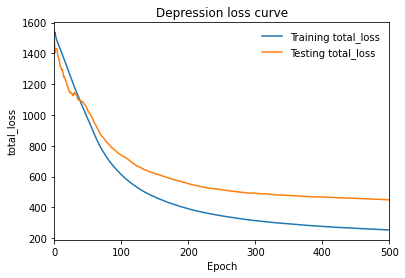

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_training_curves(train_losses, test_losses, curve_name, epoch):
    plt.clf()
    
    plt.xlim([0,epoch])
    plt.plot(train_losses, label='Training {}'.format(curve_name))
    plt.plot(test_losses, label='Testing {}'.format(curve_name))
    plt.ylabel(curve_name)
    plt.xlabel('Epoch')
    
    plt.title("Depression loss curve")
    plt.legend(frameon=False)
    plt.show()

draw_training_curves(losses['train']['total'],losses['val']['total'], 'total_loss', 500 )

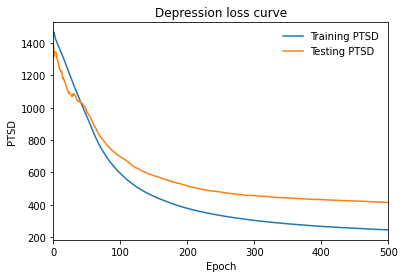

In [ ]:
draw_training_curves(losses['train']['ptsd'],losses['val']['ptsd'], 'PTSD', 500 )

In [ ]:
draw_training_curves(losses['train']['phq'],losses['val']['phq'], 'PHQ', 500 )

NameError: ignored

In [ ]:
class LSTM_Single_Task(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)


        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, sentence, sentence_length):
        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout(sentence_embed)

        sentence_pack = pack_padded_sequence(sentence_embed, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(sentence_pack)
        task_op = self.MLP(ht[-1])
  
        return torch.squeeze(task_op, 1)


In [ ]:
def train_single_task(task, model, optimizer, criterion, train_loader, val_loader, epochs):

  epoch_train_loss = []
  epoch_val_loss = []
  losses = {'train':[], 'val':[]}

  print("Training started...\n")

  model.to(DEVICE)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1, last_epoch=-1, verbose=True)
  early_stop = EarlyStopping(patience=12)
  

  for epoch in range(epochs):

    total = 0
    correct =  0
    print("Epoch : ", epoch+1)
    model.train()
    for sentence, length, phq_score, ptsd_score in train_loader:
      sentence = sentence.to(DEVICE).long()
      phq_score = phq_score.to(DEVICE).type(torch.float32)
      ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
      if task == 'PHQ':
        label = phq_score
      else:
        label = ptsd_score

      optimizer.zero_grad()

      task_op = model(sentence, length)

      loss = criterion(task_op, label)
      loss.backward()
     
      predicted = torch.round(task_op)
   
      total += label.size(0)
      correct += (predicted==label).sum().item()
      epoch_train_loss.append(loss.item())
      optimizer.step()
      
    train_loss = np.average(epoch_train_loss)
    train_accuracy = correct/total

    model.eval()
    total = 0
    correct =  0
    with torch.no_grad():
      for sentence, length, phq_score, ptsd_score in val_loader:
        sentence = sentence.to(DEVICE).long()
        phq_score = phq_score.to(DEVICE).type(torch.float32)
        ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
        if task == 'PHQ':
          label = phq_score
        else: 
          label = ptsd_score
        
        task_op = model(sentence, length)

        loss = criterion(task_op, label)
        predicted = torch.round(task_op)
  
        total += label.size(0)
        correct += (predicted==label).sum().item()
        epoch_val_loss.append(loss.item())

    val_loss = np.average(epoch_val_loss)
    val_accuracy = correct/total
    scheduler.step()
    early_stop(val_loss, model)
    

    print("Train loss: {0:.3f} Val loss: {1:.3f}".format(train_loss, val_loss))
    print("Train acc: {0:.3f} Val acc: {1:.3f}".format(train_accuracy, val_accuracy))
    print('--------------------------------------------------------------------------------------------------------------------')

    if early_stop.early_stop:
          print("Early stopping")
          used_early_stopping  = True
          break

    losses['train'].append(train_loss) 
    losses['val'].append(val_loss) 

  return model, losses

In [ ]:
vocab_size = 8353
embedding_dim = 300
hidden_dim = 256
lr = 5e-5
epochs = 500
batch_size = 16

model_task = LSTM_Single_Task(vocab_size, embedding_dim, hidden_dim, embed_matrix)
optimizer = torch.optim.Adam(model_task.parameters(), lr=lr)
criterion = torch.nn.BCELoss().to(DEVICE) 

train_loader = torch.utils.data.DataLoader(DepressionDataset(train_encoded, train_PHQ, train_PTSD), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DepressionDataset(val_encoded, val_PHQ, val_PTSD), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(DepressionDataset(test_encoded, test_PHQ, test_PTSD), batch_size=batch_size, shuffle=True)

model_task, losses = train_single_task('PTSD', model_task, optimizer, criterion, train_loader, val_loader, epochs)

Training started...

Adjusting learning rate of group 0 to 5.0000e-05.
Epoch :  1
Adjusting learning rate of group 0 to 5.0000e-05.
Train loss: 0.736 Val loss: 0.713
Train acc: 0.477 Val acc: 0.286
--------------------------------------------------------------------------------------------------------------------
Epoch :  2
Adjusting learning rate of group 0 to 5.0000e-05.
Train loss: 0.730 Val loss: 0.712
Train acc: 0.467 Val acc: 0.314
--------------------------------------------------------------------------------------------------------------------
Epoch :  3
Adjusting learning rate of group 0 to 5.0000e-05.
Train loss: 0.725 Val loss: 0.713
Train acc: 0.439 Val acc: 0.314
--------------------------------------------------------------------------------------------------------------------
Epoch :  4
Adjusting learning rate of group 0 to 5.0000e-05.
Train loss: 0.720 Val loss: 0.714
Train acc: 0.486 Val acc: 0.343
----------------------------------------------------------------------

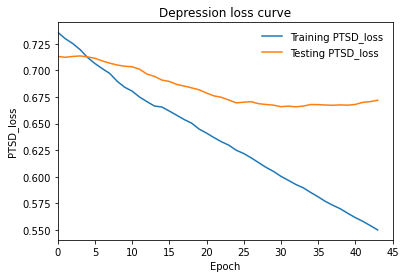

In [ ]:
draw_training_curves(losses['train'],losses['val'], 'PTSD_loss', 45 )
#PHQ 256 works best for hidden layer

In [ ]:
def evaluate_single_task(task, model, test_loader):
  output = []
  actual = []
  model.eval()
  with torch.no_grad():
    for sentence, length, phq_score, ptsd_score in test_loader:
      sentence = sentence.to(DEVICE).long()
      phq_score = phq_score.to(DEVICE).type(torch.float32)
      ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
      if task == 'PHQ':
        label = phq_score
      else: 
        label = ptsd_score
      
      phqop,ptsdop = model(sentence, length)

      output.extend(phqop.cpu().tolist())
      actual.extend(phq_score.cpu().tolist())

  return actual, output

test_loader = torch.utils.data.DataLoader(DepressionDataset(test_encoded, test_PHQ, test_PTSD), batch_size=batch_size, shuffle=False)
actual, preds = evaluate_single_task("PHQ", model, test_loader)

final_actual = []
final_pred = []

for val in actual:
  if val < 5:
    final_actual.append("None")
  elif val > 4 and val<15:
    final_actual.append("Mild to moderate")
  else:
    final_actual.append("Severe")

for val in preds:
  if val < 5:
    final_pred.append("None")
  elif val > 4 and val<15:
    final_pred.append("Mild to moderate")
  else:
    final_pred.append("Severe")

correct = 0
total = 0
for x,y in zip(final_actual, final_pred):
  if x == y:
    correct+=1
  total+=1

print("Accuracy: ", correct/total)

Accuracy:  0.425531914893617


In [ ]:
"""
References:
1. https://docs.google.com/document/d/1_PycTNBTQjboYtyZslkte0WlcdyMlyFTMYZlSHLq0EE/edit#
"""